## Tomato Plant Leaf Disease Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [12]:
image_size = 256
batch_size = 16
RBG = 3
Epcho = 3

### Load Data into tensorflow dataset

In [3]:
# only take 6 class images

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=(batch_size)
                                                   
)

Found 2879 files belonging to 6 classes.


In [4]:
class_Name=dataset.class_names
print(class_Name,len(class_Name))

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'] 6


In [5]:
len(dataset)

180

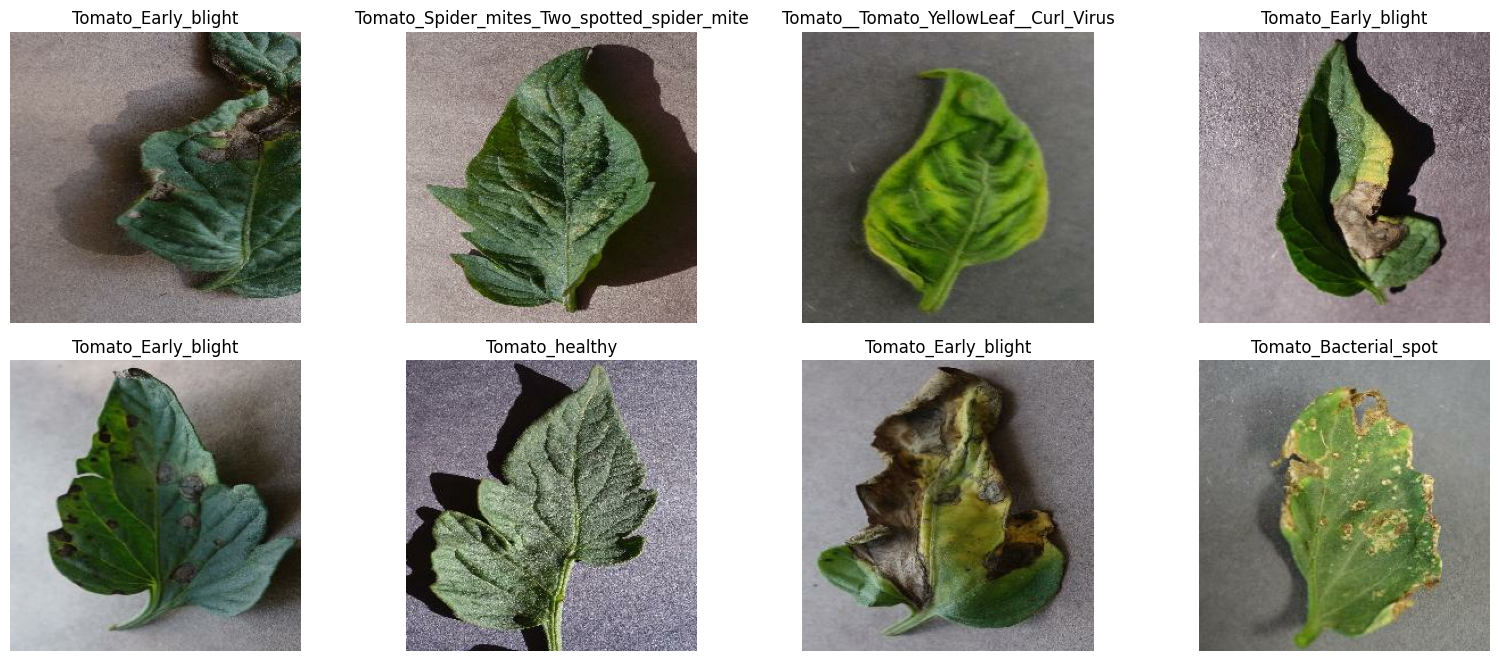

In [6]:
plt.figure(figsize=(16,10))
for image_batch,label_batch in dataset.take(1):
    for i in range (8):
        ax= plt.subplot(3,4,i+1)
        plt.title(class_Name[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
plt.tight_layout()
plt.show()

###  Function to get train,validation,and test data

In [7]:
def preprocess_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shu_size=100):
    ds_size =len(data)
    
    if shuffle:
        data = data.shuffle(shu_size,seed = 50)
    
    train_size = int(train_split * ds_size )
    
    valu_size = int(val_split*ds_size)
    
    train_ds = data.take(train_size)
    
    valu_ds = data.skip(train_size).take(valu_size)
    
    test_ds = data.skip(train_size).skip(valu_size)
    
    return train_ds,valu_ds,test_ds

In [8]:
train_ds,valu_ds,test_ds=preprocess_tf(dataset)

In [9]:
len(train_ds),len(valu_ds),len(test_ds)

(144, 18, 18)

### Data Augmentation and Resizing

In [33]:
# Cache the dataset to improve performance by avoiding redundant data loading and preprocessing
# prefetch will fetching the next batch of data while the current batch is being processed.

train_ds=train_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
valu_ds=valu_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

### Model building

In [15]:
input_shape = (batch_size,image_size,image_size,RBG)
n_class = 6
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(20,(2,2),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(2,2),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_class,activation='softmax')
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 255, 255, 20)        260       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 126, 126, 64)        5184      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 63, 63, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs= Epcho,
    batch_size=batch_size,
    verbose=1,
    validation_data=valu_ds
)

Epoch 1/3
144/144 [==============================] - 640s 4s/step - loss: 1.1750 - accuracy: 0.5371 - val_loss: 0.8543 - val_accuracy: 0.6979
Epoch 2/3
144/144 [==============================] - 254s 2s/step - loss: 0.5662 - accuracy: 0.7833 - val_loss: 0.4560 - val_accuracy: 0.8403
Epoch 3/3
144/144 [==============================] - 183s 1s/step - loss: 0.4002 - accuracy: 0.8528 - val_loss: 0.4092 - val_accuracy: 0.8264


## Prediction

first image to predict
actual label : Tomato__Tomato_YellowLeaf__Curl_Virus
predcted label: Tomato__Tomato_YellowLeaf__Curl_Virus


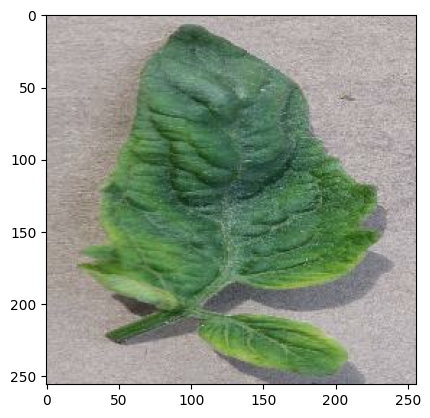

In [19]:
for image_ba, label_ba in test_ds.take(1):
    first_image = image_ba[0].numpy().astype('uint8')
    first_label =  label_ba[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label :',class_Name[first_label])
    
    batch_prediction = model.predict(image_ba,verbose=0)
    print("predcted label:",class_Name[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array,verbose=0)

    predicted_class = class_Name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

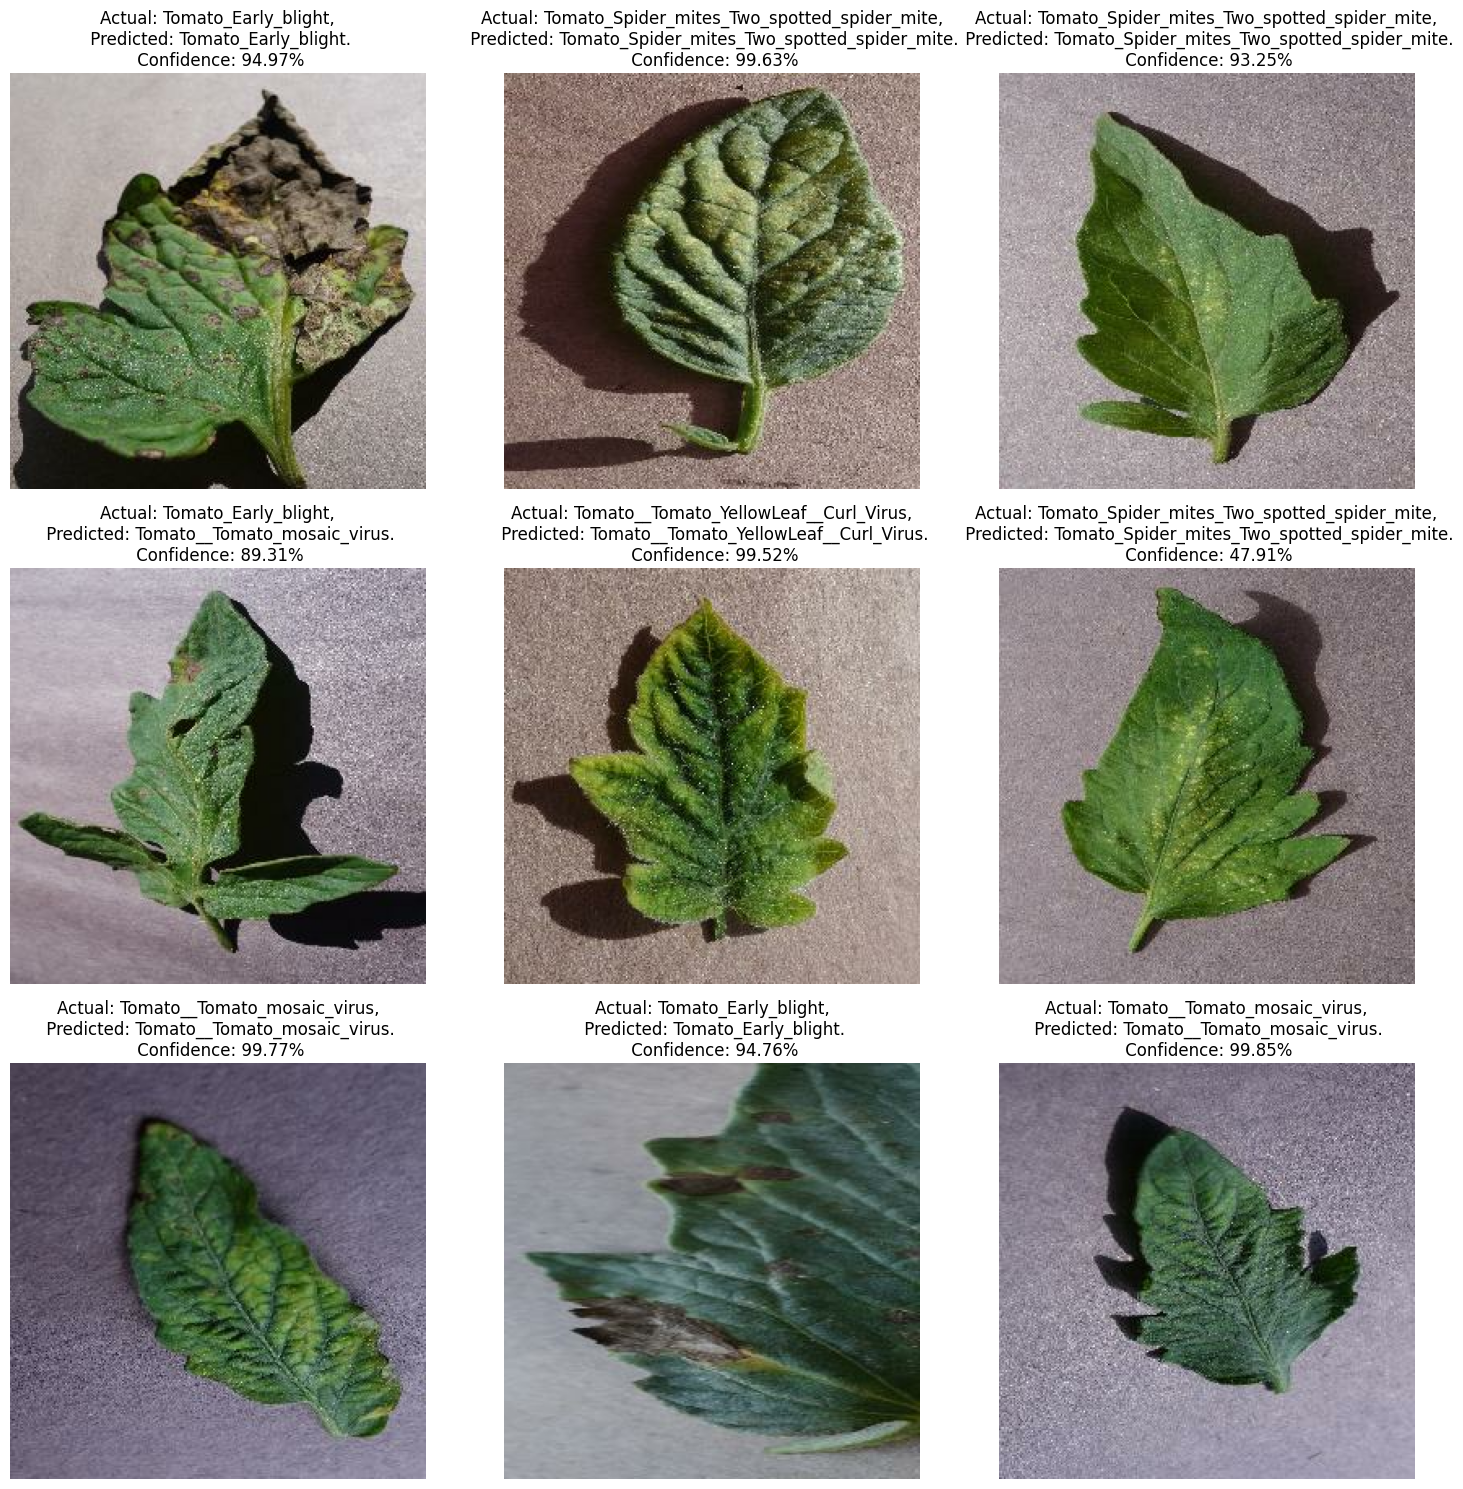

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_Name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()
plt.show()

### Saving Model

In [34]:
model.save("tomato_model.h5")

C:\Users\HP\anaconda3\envs\potato_cnn\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
scores=model.evaluate(test_ds)

18/18 [==============================] - 14s 695ms/step - loss: 0.5391 - accuracy: 0.8056


In [24]:
scores

[0.5391380786895752, 0.8055555820465088]

In [25]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 144}

In [26]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

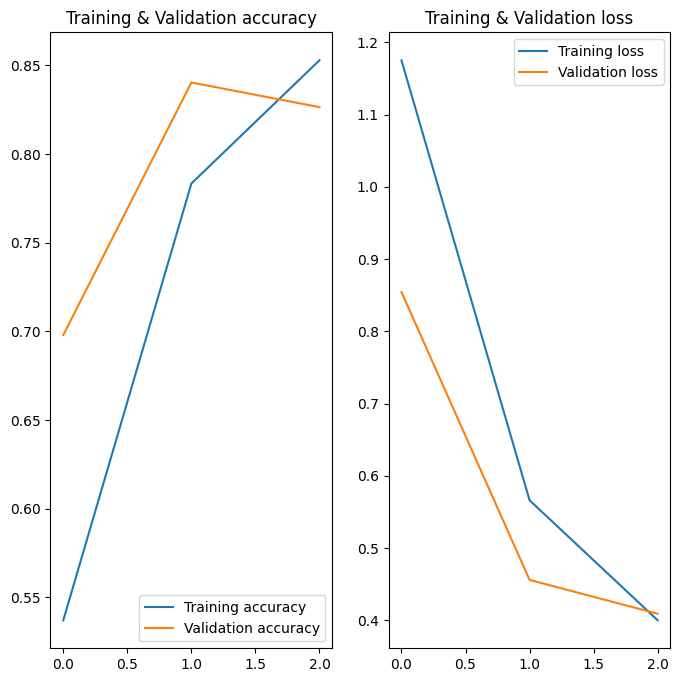

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epcho),acc,label='Training accuracy')
plt.plot(range(Epcho),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epcho),loss,label='Training loss')
plt.plot(range(Epcho),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training & Validation loss')
plt.show()

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array,verbose=0)

    predicted_class = class_Name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

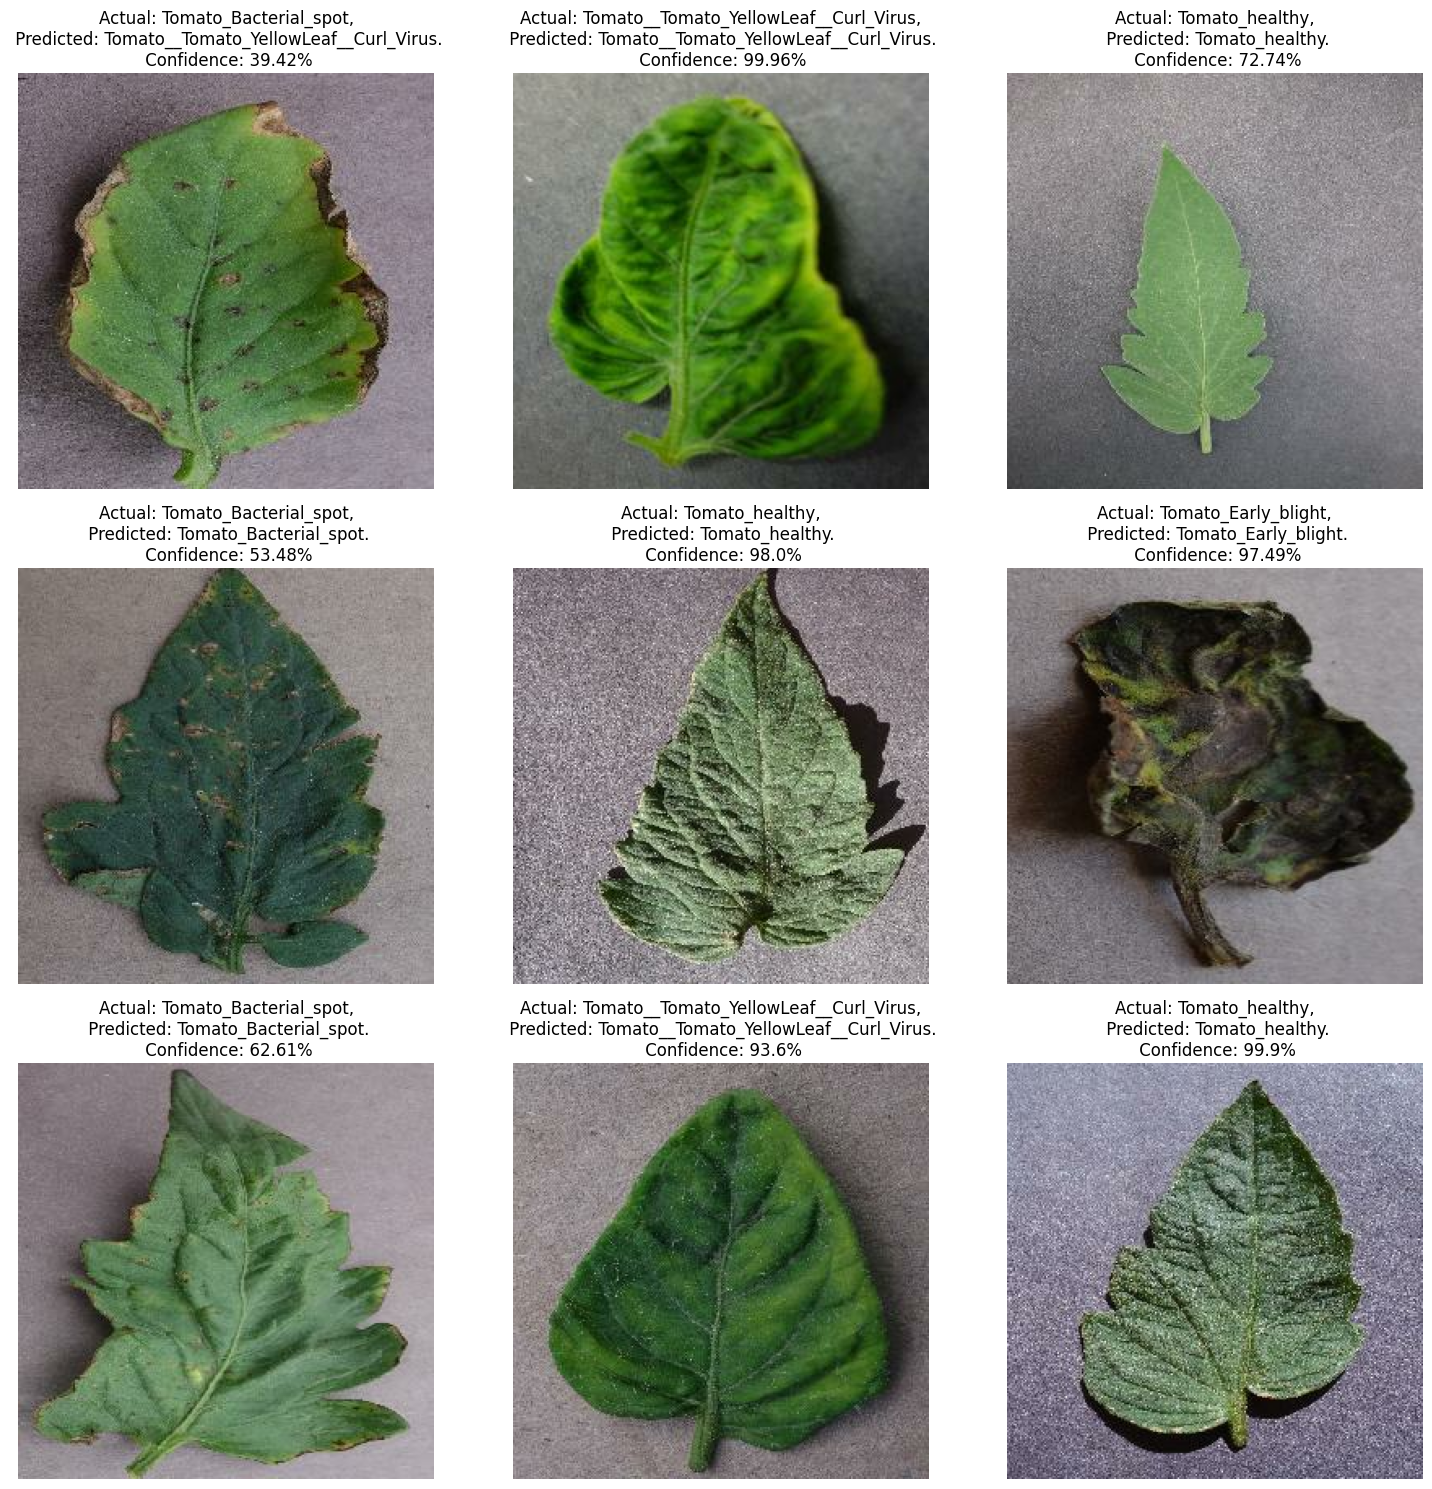

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_Name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
plt.tight_layout()
plt.show()

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch,verbose=0)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(label_batch.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_Name)

print(class_report)

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.86      0.65      0.74        49
                        Tomato_Early_blight       0.81      0.65      0.72        60
Tomato_Spider_mites_Two_spotted_spider_mite       0.70      0.78      0.74        54
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.84      0.88      0.86        52
                Tomato__Tomato_mosaic_virus       0.72      1.00      0.84        31
                             Tomato_healthy       0.93      1.00      0.97        42

                                   accuracy                           0.81       288
                                  macro avg       0.81      0.83      0.81       288
                               weighted avg       0.81      0.81      0.80       288



Text(120.72222222222221, 0.5, 'True label')

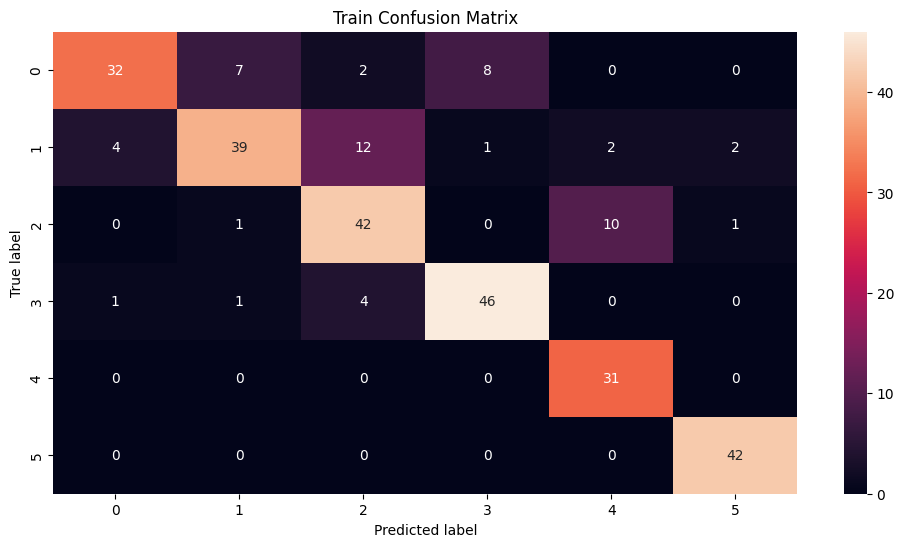

In [31]:
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')